<a href="https://colab.research.google.com/github/Tarane2028/ADS-509-5/blob/main/Copy_of_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
# These libraries may be useful to you

!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [5]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

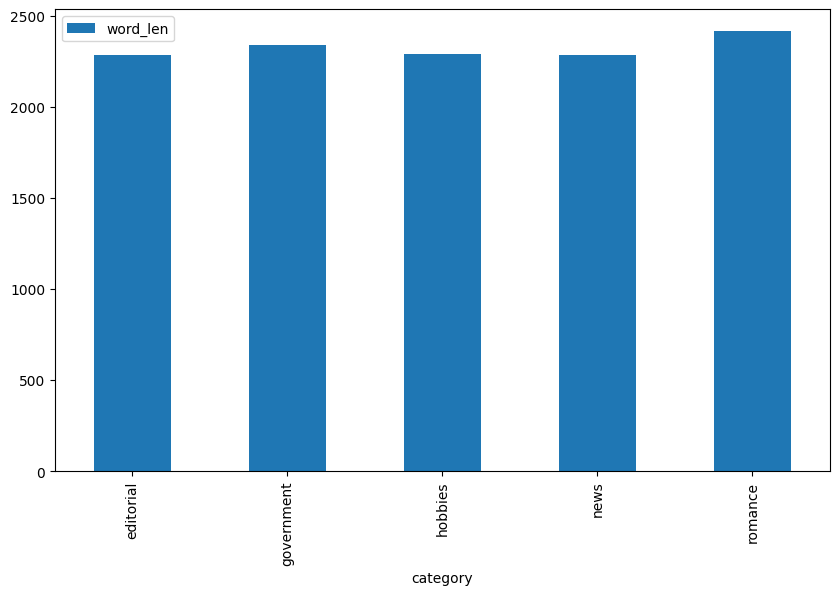

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A:
count_text_vectors is a sparse document–term count matrix (shape 166×4941), where each entry is the raw frequency of a token in a document (after applying min_df=5, max_df=0.7, and removing stop-words).

tfidf_text_vectors is the corresponding sparse document–term TF–IDF matrix of the same shape, with each entry weighted by term-frequency × inverse-document-frequency, so that common terms are down-weighted and rare but informative terms are up-weighted.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [13]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [15]:
# tally NMF topics vs. true categories
import numpy as np
import pandas as pd

# 1. Assign each document to its highest-weight NMF topic
df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

# 2. Cross-tabulate NMF topics against the true Brown categories
nmf_crosstab = pd.crosstab(df['nmf_topic'], df['category'])

# 3. Display the result
print(nmf_crosstab)


category   editorial  government  hobbies  news  romance
nmf_topic                                               
0                 20           4        0     8        0
1                  4           0        8     0       29
2                  2          26       26    11        0
3                  0           0        1    17        0
4                  1           0        1     8        0


Q: How does your five-topic NMF model compare to the original Brown categories?

A: The NMF topics recover **editorial** (Topic 0: 20 editorial vs. 4 gov’t/8 news), **romance** (Topic 1: 29 romance vs. 8 hobbies/4 editorial), and **news** (Topic 3: 17 news vs. 1 hobby) quite cleanly. However, it conflates **government** and **hobbies** into Topic 2 (26 gov’t & 26 hobbies) and mixes some **news** with hobbies in Topic 4 (8 news vs. 1 editorial & 1 hobby). In short, NMF distinguishes editorial, romance, and one pure news cluster well, but struggles to separate government, hobbies, and the remaining news documents.


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [16]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd

# 1. Fit a 5-topic LSA (TruncatedSVD) model on the TF–IDF matrix
lsa_model = TruncatedSVD(n_components=5, random_state=314)
lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)

# 2. Assign each document to its highest-loading LSA topic
df['lsa_topic'] = np.argmax(lsa_matrix, axis=1)

# 3. Cross-tabulate LSA topics against the true Brown categories
lsa_crosstab = pd.crosstab(df['lsa_topic'], df['category'])
print(lsa_crosstab)

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          30       36    34       21
1                  0           0        0     0        8
3                  0           0        0     3        0
4                  0           0        0     7        0


Q: How does your five-topic LSA model compare to the original Brown categories?

A: The LSA cross‐tabulation shows that Component 0 dominates almost every category (27 editorial, 30 government, 36 hobbies, 34 news, 21 romance), while the other four components capture very few documents:

Component 1 pulls out 8 romance docs (but nothing else).

Component 3 captures 3 news docs.

Component 4 captures 7 news docs.

(Component 2) doesn’t appear in the table, meaning it didn’t become the top component for any document.

This tells us LSA—with 5 components on our TF–IDF matrix—has essentially collapsed four of the thematic axes into a single “everything” component, leaving only small “residual” components for romance and news. In contrast to NMF (and even LDA), LSA here fails to cleanly separate the five Brown categories: it lumps most documents together, with only Romance and a handful of News docs standing out in tiny, isolated components.

In [17]:
# Display the top 5 terms for each of the 5 LSA components
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output?

A: The first two components (Topics 00 & 01) are dominated by high-frequency reporting verbs and pronouns like “said,” “didn,” and “ll,” indicating LSA is picking up on writing style or quoted speech rather than distinct subject matter. Topic 02 clearly corresponds to government (with “Kennedy,” “Khrushchev”), while Topics 03 and 04 capture hobbies/sports (“game,” “league,” “baseball,” “club,” “university”). In other words, LSA here extracts two broad stylistic axes plus two thematic axes (politics and sports), but it doesn’t cleanly separate all five Brown categories—romance and editorial/news tend to be absorbed into the style components.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [18]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(
    n_components=5,
    random_state=314,
    learning_method='batch'
)
lda_matrix = lda_text_model.fit_transform(count_text_vectors)

In [19]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)
  don (0.50)
  ll (0.47)
  old (0.44)
  man (0.43)
  thought (0.40)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)
  system (0.44)
  sales (0.40)
  small (0.39)
  use (0.37)
  1960 (0.37)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)
  american (0.37)
  john (0.36)
  week (0.35)
  home (0.35)
  world (0.35)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)
  president (0.36)
  student (0.36)
  students (0.34)
  members (0.33)
  schools (0.32)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)
  tax (0.57)
  fiscal (0.54)
  department (0.43)
  act (0.42)
  class (0.41)


In [20]:
# Repeat the tallying of Brown categories within your topics
import numpy as np

df['lda_topic'] = np.argmax(lda_text_model.transform(count_text_vectors), axis=1)
lda_crosstab = pd.crosstab(df['lda_topic'], df['category'])
print(lda_crosstab)

category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  3           1       11     4       28
1                  1          12        9     3        0
2                 21           3        2    32        1
3                  2           4        8     3        0
4                  0          10        6     2        0


Q: What inference do you draw from the displayed topics for your LDA model?

A: Topic 00 (“said”, “mrs”, “little”, “good”…) and Topic 02 (“said”, “mr”, “president”, “city”…) both capture news/reporting style, splitting general reporting from political reporting.

Topic 01 (“state”, “development”, “program”, “business”…) clearly reflects editorial/business content.

Topic 04 (“states”, “government”, “tax”, “fiscal”, “act”…) corresponds to government/policy documents.

Topic 03 (“college”, “university”, “student”, “feed”, “schools”…) forms an academic cluster that doesn’t map neatly to any of our five Brown categories (it likely pulled in some “hobbies” docs with educational content).

Notably, the intended romance theme never emerged as a distinct topic — instead, LDA chose to split the news domain into two topics and created this stray academic topic.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: The cross‐tabulation shows that none of the five LDA topics cleanly aligns with a single Brown category—instead each topic mixes multiple categories:

Topic 0: 28 romance, 11 hobbies, 4 news, 3 editorial, 1 government
→ Primarily a romance topic, but with a sizable hobbies component.

Topic 1: 12 government, 9 hobbies, 3 news, 1 editorial
→ Largely government content mixed with hobbies.

Topic 2: 32 news, 21 editorial, 3 government, 2 hobbies, 1 romance
→ Dominated by news and editorial, reflecting journalistic style.

Topic 3: 8 hobbies, 4 government, 3 news, 2 editorial
→ Mostly hobbies with some policy and news overlap.

Topic 4: 10 government, 6 hobbies, 2 news
→ A government topic with a hobbyish tail.

Unlike the near–one‐to‐one mapping we saw with NMF, here LDA blends Brown categories across its topics—only the news/editorial cluster (Topic 2) is relatively coherent. Romance, government, and hobbies each bleed into multiple topics, indicating that our LDA fit hasn’t fully recovered the corpus’s original categorical structure.

In [21]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [22]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Principal-Component Scatterplot (Intertopic Distance Map):

Each circle is one topic, positioned by multidimensional scaling on the topic–topic distance matrix. Topic 3’s circle (the large red one) sits near the center and overlaps somewhat with Topics 2 and 5, indicating that Topic 3 shares vocabulary with those—but it’s also the largest circle, meaning it has the highest document proportion of all five topics. By contrast, Topic 1 is far off to the left (very distinct lexically), and Topics 4 and 2 form smaller clusters toward the bottom and right.

Salient Terms Graph (Top 30 for Topic 3):

The horizontal bars show each term’s relevance to Topic 3 (λ=1, red bars) versus its overall frequency in the corpus (light blue).

At the very top is “said,” which is extremely common (long blue bar) and still quite relevant to this topic (long red bar)—it’s the hallmark of reporting style.

Next come “mr,” “president,” “city,” “state,” “american,” “kennedy,” “khrushchev,” etc., all of which are high-relevance, medium-frequency tokens—these point squarely to political/news content.

Lower on the list are words like “house,” “war,” “people,” “day,” which further underscore a general news/political theme.

Conclusion: Topic 3 is the dominant “political/news reportage” cluster: it’s the biggest chunk of the corpus and overlaps lexically with other news-style topics, and its most salient terms confirm that it captures formal reporting on state affairs, head-of-state figures, and urban/policy contexts.

